# Importing the dependencies
https://www.kaggle.com/code/pratik1120/let-s-find-the-best-course-at-cheapest-price/notebook#Which-subject-consist-of-most-expensive-courses?----%3E-Web-Development

In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from pandasql import sqldf
from wordcloud import WordCloud
from scipy.stats import skew,yeojohnson,boxcox
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pycaret.regression import *

This dataset contains 3.682 records of courses from 4 subjects (Business Finance, Graphic Design, Musical Instruments and Web Design) taken from Udemy.
Udemy is a massive online open course (MOOC) platform that offers both free and paid courses. Anybody can create a course, a business model by which allowed Udemy to have hundreds of thousands of courses.

In [2]:
# Reading the data from csv file into dataframe
data = pd.read_csv('data.csv')
data.head(5)

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,True,200,2147,23,51,All Levels,1.5,2017-01-18T20:58:58Z,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,True,75,2792,923,274,All Levels,39.0,2017-03-09T16:34:20Z,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,True,45,2174,74,51,Intermediate Level,2.5,2016-12-19T19:26:30Z,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,True,95,2451,11,36,All Levels,3.0,2017-05-30T20:07:24Z,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,True,200,1276,45,26,Intermediate Level,2.0,2016-12-13T14:57:18Z,Business Finance


# Stage 1: Data cleaning 🔨

In [3]:
# Dropping attriutes and resetting index
data.drop(['course_id','url'],inplace=True,axis=1)
data.reset_index(drop=True,inplace=True)

In [4]:
year_list = []
month_list = []
day_list = []
hour_UTC_list = []

for i in range(len(data)):
    timestamp = data.iloc[i].published_timestamp
    datetime_obj = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%SZ")

    # Extract individual components and append to lists
    year_list.append(datetime_obj.year)
    month_list.append(datetime_obj.month)
    day_list.append(datetime_obj.day)
    hour_UTC_list.append(datetime_obj.hour)

In [5]:
# Creating new features
data['year'] = year_list
data['month'] = month_list
data['day'] = day_list
data['hour_UTC'] = hour_UTC_list

# Dropping the published_timestamp feature
data.drop(['published_timestamp'],axis=1,inplace=True)

# Stage 2: Train test split
Determining the correct order of data processing and train-test split is crucial for ensuring reliable and unbiased results in your models. Performing the train test split before processing the data having a lot of pros and these are mentioned below

- Prevents data leakage: Only training data is used for processing and feature engineering, preventing information from the test set influencing the model.
- Preserves test set integrity: The test set remains untouched, ensuring it truly represents unseen data for unbiased evaluation.
- Standard practice: Splitting data before processing is a common best practice in machine learning.

In [6]:
# Seperatin the data in dependent and independent variable
X = data.drop(['num_subscribers'],axis=1)
y = data['num_subscribers']

# Performing the train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state = 1,shuffle=True)
print("Training data size:",X_train.shape)
print("Test data size:",X_test.shape)

Training data size: (2942, 12)
Test data size: (736, 12)


In [7]:
# Creating dataframe for analysis and training
df = pd.concat([X_train, y_train], axis=1)
df.reset_index(drop=True,inplace=True)

# Exploratory data analysis

In [8]:
# Checking the shape
df.shape

(2942, 13)

In [9]:
# Checking any 5 random rows
df.sample(5)

,course_title,is_paid,price,num_reviews,num_lectures,level,content_duration,subject,year,month,day,hour_UTC,num_subscribers
1503,Become A Full Stack Web Developer in 14 Days,True,195,20,126,All Levels,13.500000,Web Development,2016,11,23,4,467
2388,Angular Styling & Animations (for Angular 2 an...,True,120,307,107,Intermediate Level,6.000000,Web Development,2017,3,28,0,4138
127,Better way towards CSS using Less and Sass,True,20,44,26,All Levels,1.500000,Web Development,2016,2,16,8,2227
2634,Learn To Draw - The COMIC BOOK STYLE,True,55,14,19,All Levels,2.000000,Graphic Design,2012,6,1,21,363
2535,Investment Crowdfunding 101 (a.k.a Equity Crow...,False,0,181,11,Beginner Level,0.533333,Business Finance,2016,5,17,0,4607


In [10]:
# Information about the column datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2942 entries, 0 to 2941
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   course_title      2942 non-null   object 
 1   is_paid           2942 non-null   bool   
 2   price             2942 non-null   int64  
 3   num_reviews       2942 non-null   int64  
 4   num_lectures      2942 non-null   int64  
 5   level             2942 non-null   object 
 6   content_duration  2942 non-null   float64
 7   subject           2942 non-null   object 
 8   year              2942 non-null   int64  
 9   month             2942 non-null   int64  
 10  day               2942 non-null   int64  
 11  hour_UTC          2942 non-null   int64  
 12  num_subscribers   2942 non-null   int64  
dtypes: bool(1), float64(1), int64(8), object(3)
memory usage: 278.8+ KB


In [11]:
# Checking if there are any duplicate values and if so removing them
duplicate_values= df.duplicated().sum()
print("Duplicate values : ",df.duplicated().sum())
if duplicate_values != 0:
    df.drop_duplicates(inplace=True)
    print("Duplicate values : ",df.duplicated().sum())

Duplicate values :  4
Duplicate values :  0


In [12]:
# Checking the sum and percentage of missing values
nan_count = df.isnull().sum()
nan_percentage = df.isnull().mean()*100
nan_analysis = pd.DataFrame({'Sum': nan_count, 'Percentage %': nan_percentage}, index=nan_count.index)
nan_analysis

,Sum,Percentage %
course_title,0,0.0
is_paid,0,0.0
price,0,0.0
num_reviews,0,0.0
num_lectures,0,0.0
level,0,0.0
content_duration,0,0.0
subject,0,0.0
year,0,0.0
month,0,0.0


In [13]:
df[(df['num_subscribers']<5000)].shape

(2491, 13)

In [14]:
df[(df['num_subscribers']>5000) & (df['num_subscribers']<15000)].shape

(330, 13)

In [15]:
df[(df['num_subscribers']>15000)].shape

(116, 13)

### Distribution and outlier analysis
For doing better feature engineering and model selection it is important for us to be aware about the distribution of the numerical features in our dataset. So now we will first try to understand the distribution of each of the numerical feature and based on that we will move with outlier analysis

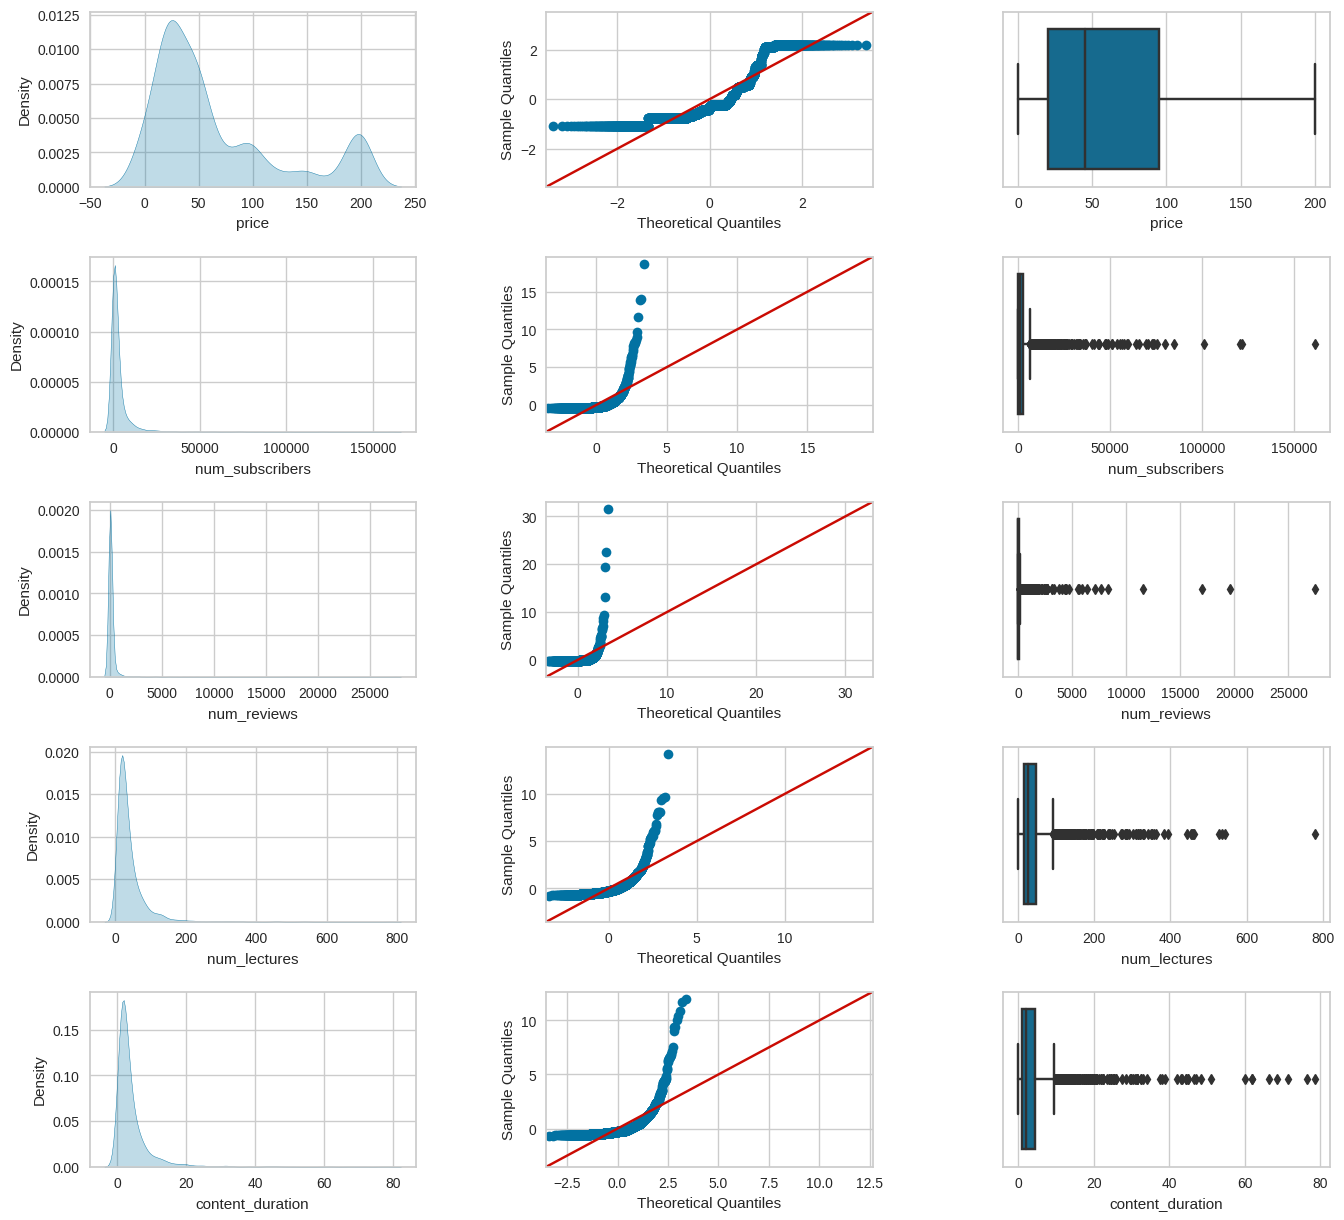

In [16]:
# Create a 5x3 grid of subplots (5 rows, 3 columns)
fig, ax = plt.subplots(5, 3, figsize=(16, 15))

# Plot KDE plots in the first column
sns.kdeplot(data=df, x='price', ax=ax[0, 0], shade=True)
sns.kdeplot(data=df, x='num_subscribers', ax=ax[1, 0], shade=True)
sns.kdeplot(data=df, x='num_reviews', ax=ax[2, 0], shade=True)
sns.kdeplot(data=df, x='num_lectures', ax=ax[3, 0], shade=True)
sns.kdeplot(data=df, x='content_duration', ax=ax[4, 0], shade=True)

# Plot Q-Q plots in the second column
sm.qqplot(df['price'], line='45', ax=ax[0, 1], fit=True)
sm.qqplot(df['num_subscribers'], line='45', ax=ax[1, 1], fit=True)
sm.qqplot(df['num_reviews'], line='45', ax=ax[2, 1], fit=True)
sm.qqplot(df['num_lectures'], line='45', ax=ax[3, 1], fit=True)
sm.qqplot(df['content_duration'], line='45', ax=ax[4, 1], fit=True)

# Plot box plots in the third column
sns.boxplot(x = 'price', data = df, ax=ax[0, 2])
sns.boxplot(x = 'num_subscribers', data = df, ax=ax[1, 2])
sns.boxplot(x = 'num_reviews', data = df, ax=ax[2, 2])
sns.boxplot(x = 'num_lectures', data = df, ax=ax[3, 2])
sns.boxplot(x = 'content_duration', data = df, ax=ax[4, 2])

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

At first glance I can see that the distribution is heavily skewed on right side and almost all distributions are looking like log normal distribution and applying log operation on the distribution will make this as normal distribution.But the issue is that log(0) is `undefined` and there are some considerable number of tuples having above attribute values as 0 so in order to deal with this skewness we need to use some other mathematical transformation. But before that I think we must explore why the values are 0, because course having 0 subscribers is little strange. In this small data analysis section I will try to find out the answers of the following questions.

- What is the count of courses having 0 subscribers and what is the reason behind 0 subscribers?
- Why certain courses have high number of subscriber count/reviews?
- What is the averge price,content duration and number of lectures of hightly popular courses

In [17]:
print("Courses with 0 subscribers : ",df[df['num_subscribers'] == 0].shape[0])

# Avg_PS0 means Average price of 0 subscriber count
Avg_PS0 = df[df['num_subscribers'] == 0]['price'].mean()
Avg_PSN0 = df[df['num_subscribers'] > 0]['price'].mean()

# Avg_CDS0 means Average content duration of 0 subscriber count
Avg_CDS0 = df[df['num_subscribers'] == 0]['content_duration'].mean()
Avg_CDN0 = df[df['num_subscribers'] > 0]['content_duration'].mean()

# Avg_NLS0 means Average number of lectures of 0 subscriber count
Avg_NLS0 = df[df['num_subscribers'] == 0]['num_lectures'].mean()
Avg_NLN0 = df[df['num_subscribers'] > 0]['num_lectures'].mean()


Subscriber_analysis_df = pd.DataFrame({
    "0 Subscriber": [Avg_PS0, Avg_CDS0, Avg_NLS0],
    "Not 0 Subscriber": [Avg_PSN0, Avg_CDN0, Avg_NLN0]
}, index=["Avg Price", "Avg Content Duration", "Avg Number of Lectures"])
Subscriber_analysis_df

Courses with 0 subscribers :  52


,0 Subscriber,Not 0 Subscriber
Avg Price,48.173077,65.708593
Avg Content Duration,1.515064,4.193907
Avg Number of Lectures,11.519231,41.299030


In [18]:
# How many 0 subscriber courses are paid
df[df['num_subscribers'] == 0]['is_paid'].value_counts()

True    52
Name: is_paid, dtype: int64

In [19]:
# Subject of most loved courses (outliers)
df[df['num_subscribers']>80000]['subject'].value_counts()

Web Development        4
Musical Instruments    1
Name: subject, dtype: int64

In [20]:
# Excluding the outliers the most famous courses are having number of subcribers 100+ to 70,000 
famous_df = df[(df['num_subscribers'] > 100) & (df['num_subscribers'] < 70000)]
print("Average Price : ", round(famous_df['price'].mean(), 2))
print("Average number of subscribers : ", round(famous_df['num_subscribers'].mean(), 2))
print("Average num of reviews : ", round(famous_df['num_reviews'].mean(), 2))
print("Average num of lectures : ", round(famous_df['num_lectures'].mean(), 2))
print("Average content duration : ", round(famous_df['content_duration'].mean(), 2))
print("Percentage of paid courses : ",round((famous_df['is_paid'].value_counts()[True]/famous_df.shape[0])*100,2))

print("________________________")
category_counts = famous_df['subject'].value_counts()
percentages = (category_counts / famous_df.shape[0]) * 100
print(percentages)

Average Price :  69.99
Average number of subscribers :  3700.54
Average num of reviews :  159.18
Average num of lectures :  44.56
Average content duration :  4.58
Percentage of paid courses :  88.41
________________________
Web Development        42.318059
Business Finance       29.694519
Graphic Design         14.555256
Musical Instruments    13.432165
Name: subject, dtype: float64


### Results of analysis

1. Courses having 0 subscribers are generally cheaper and have less number of lectures and content duration that the courses having more than 0 subscribers and at this stage it is little awkward because generally people look for cheaper and short duration courses. And the answer to this strange behaviour is because all the courses having 0 subscribers are `paid courses!`
2. Out of all extremely popular courses (outliers) around `89%` of courses are related to `Web development`

# Data processing
- Tranforming the non-gaussian attributes
- Categorical attribute encoding
- Feature scaling
- Natural language processing

In [21]:
# There is a course having 0 lectures
df.drop(df[df['num_lectures'] == 0].index,inplace=True,axis=0)

### Removing outliers

In [22]:
print("Index of tuples having more than 3000 reviews :",df[df['num_reviews']>3000].index)
print("Index of tuples having more than 70000 subscribers :",df[df['num_subscribers']>70000].index)
print("Index of tuples having more than 400 lectures :",df[df['num_lectures']>400].index)
print("Index of tuples having more than 50 hours :",df[df['content_duration']>50].index)

Index of tuples having more than 3000 reviews : Int64Index([ 251,  422,  427,  464,  734,  858,  963, 1026, 1043, 1067, 1243,
            1341, 1858, 1946, 1999, 2150, 2419, 2463, 2594, 2740, 2744],
           dtype='int64')
Index of tuples having more than 70000 subscribers : Int64Index([367, 383, 422, 734, 951, 1026, 1171, 1656, 1946, 2150, 2744], dtype='int64')
Index of tuples having more than 400 lectures : Int64Index([101, 155, 501, 514, 770, 1355, 1398, 1969, 2221], dtype='int64')
Index of tuples having more than 50 hours : Int64Index([501, 678, 1400, 1405, 1969, 2221, 2528, 2840, 2927], dtype='int64')


In [23]:
# Dropping tuples having number of reviews more than 3000 and also price more than 70000
df.drop([251,  422,  427,  464,  734,  858,  963, 1026, 1043, 1067, 1243, 1341,
       1858, 1946, 1999, 2150, 2419, 2463, 2594, 2740, 2744,367, 383, 422, 734, 951, 1026, 1171, 1656, 1946, 2150, 2744,
        101, 155, 501, 514, 770, 1355, 1398, 1969, 2221,678, 1400, 1405, 2528, 2840, 2927],axis=0,inplace=True)

In [24]:
# Resetting the indexs
df.reset_index(drop=True,inplace=True)

### Feature transformation

In [25]:
# Calculate skewness before transformations
before_transformation = {
    'price': skew(df['price']),
    'num_subscribers': skew(df['num_subscribers']),
    'num_reviews': skew(df['num_reviews']),
    'num_lectures': skew(df['num_lectures']),
    'content_duration': skew(df['content_duration'])
}

# Apply square root and cube root transformations
sqrt_transformation = {
    'price': skew(np.sqrt(df['price'])),
    'num_subscribers': skew(np.sqrt(df['num_subscribers'])),
    'num_reviews': skew(np.sqrt(df['num_reviews'])),
    'num_lectures': skew(np.sqrt(df['num_lectures'])),
    'content_duration': skew(np.sqrt(df['content_duration']))
}

cube_root_transformation = {
    'price': skew(np.cbrt(df['price'])),
    'num_subscribers': skew(np.cbrt(df['num_subscribers'])),
    'num_reviews': skew(np.cbrt(df['num_reviews'])),
    'num_lectures': skew(np.cbrt(df['num_lectures'])),
    'content_duration': skew(np.cbrt(df['content_duration']))
}

# Yeo Johsnon transformation (We have to find our labmda value prior)
yeojohn_transformation = {
    'price': skew(yeojohnson(df['price'],0.33)),
    'num_subscribers': skew(yeojohnson(df['num_subscribers'],0.12)),
    'num_reviews': skew(yeojohnson(df['num_reviews'],-0.05)),
    'num_lectures': skew(yeojohnson(df['num_lectures'],-0.23)),
    'content_duration': skew(yeojohnson(df['content_duration'],-0.65))
}

yeojohn_transformation = {
    'price': skew(yeojohnson(df['price'],0.33)),
    'num_subscribers': skew(yeojohnson(df['num_subscribers'],0.12)),
    'num_reviews': skew(yeojohnson(df['num_reviews'],-0.05)),
    'num_lectures': skew(yeojohnson(df['num_lectures'],-0.23)),
    'content_duration': skew(yeojohnson(df['content_duration'],-0.65))
}

# Create the DataFrame with all transformations
skew_df = pd.DataFrame({
    'Normal': before_transformation,
    'Sqrt': sqrt_transformation,
    'Cube Root': cube_root_transformation,
    'Yeo-Johnson': yeojohn_transformation,
})
skew_df

,Normal,Sqrt,Cube Root,Yeo-Johnson
price,1.205176,0.246974,-0.615840,-0.068099
num_subscribers,5.393522,1.893456,0.941538,-0.098413
num_reviews,5.934206,2.633785,1.471772,0.038634
num_lectures,3.388026,1.595761,1.127309,-0.037455
content_duration,3.765372,1.773819,1.278011,0.104648


In [26]:
yeojohnson(df['content_duration'])

(array([0.69552273, 0.86535843, 1.01000482, ..., 0.79201655, 0.92336243,
        1.0722646 ]),
 -0.6321359433743551)

In [27]:
# Transforming the values
lambda_values = [0.127,-0.05,-0.19,-0.63]
columns = ['num_subscribers','num_reviews','num_lectures','content_duration']

for i in range(len(lambda_values)):
    df[columns[i]] = yeojohnson(df[columns[i]],lambda_values[i])

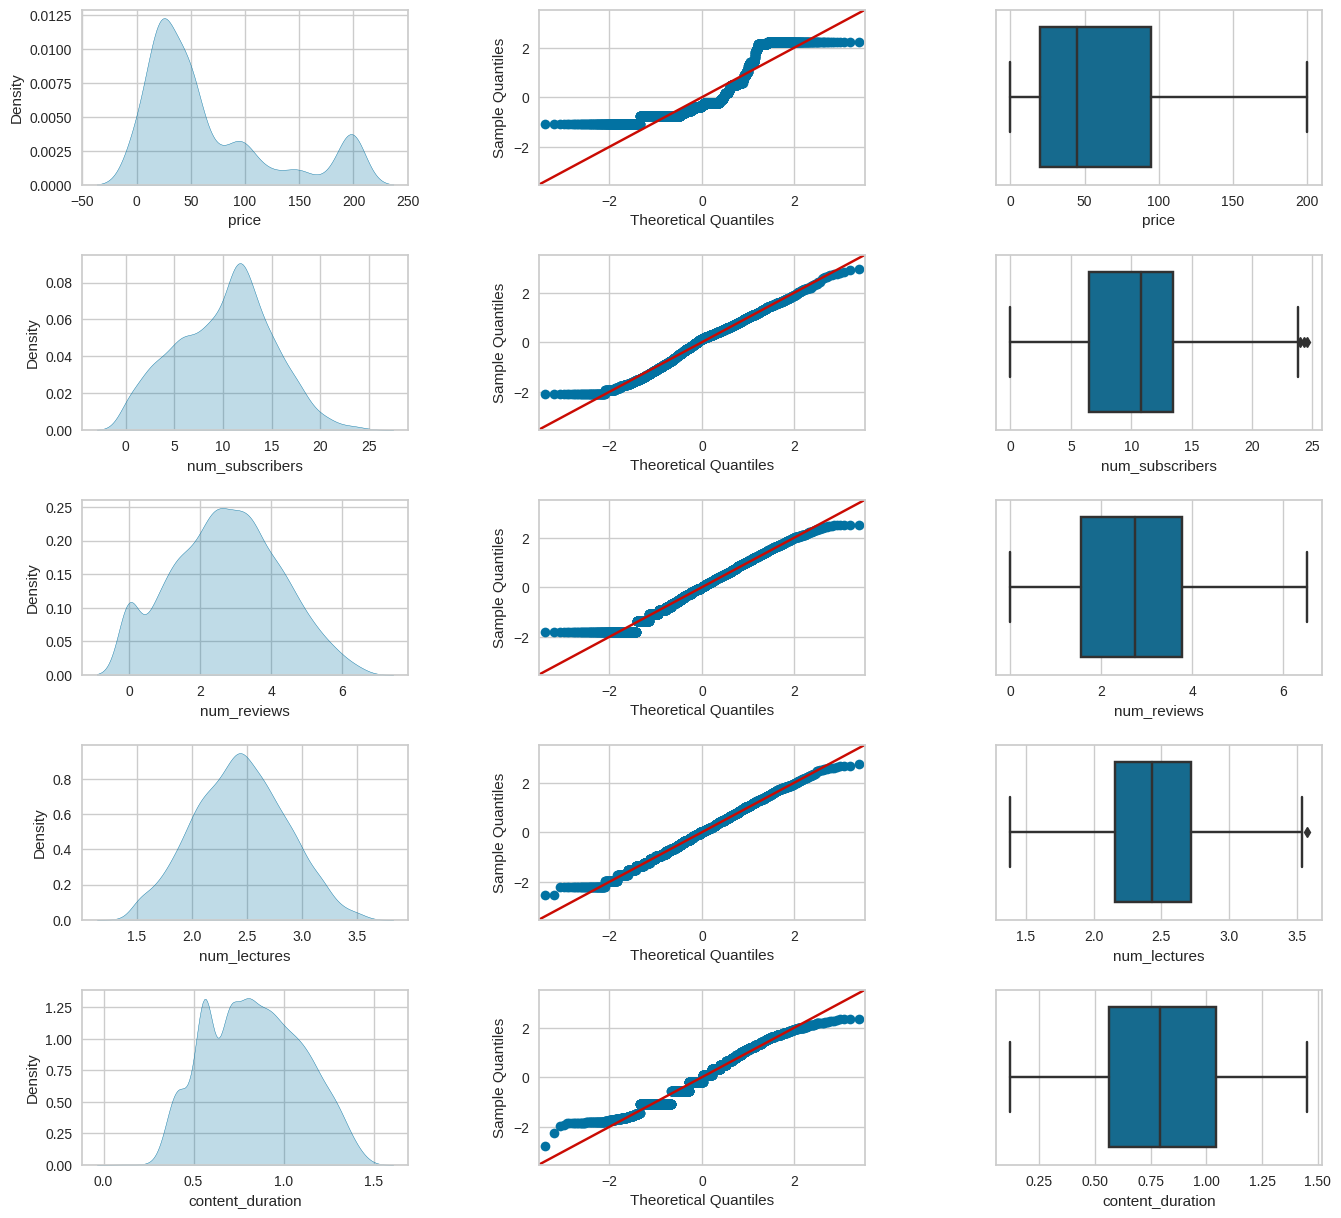

In [28]:
# Create a 5x3 grid of subplots (5 rows, 3 columns)
fig, ax = plt.subplots(5, 3, figsize=(16, 15))

# Plot KDE plots in the first column
sns.kdeplot(data=df, x='price', ax=ax[0, 0], shade=True)
sns.kdeplot(data=df, x='num_subscribers', ax=ax[1, 0], shade=True)
sns.kdeplot(data=df, x='num_reviews', ax=ax[2, 0], shade=True)
sns.kdeplot(data=df, x='num_lectures', ax=ax[3, 0], shade=True)
sns.kdeplot(data=df, x='content_duration', ax=ax[4, 0], shade=True)

# Plot Q-Q plots in the second column
sm.qqplot(df['price'], line='45', ax=ax[0, 1], fit=True)
sm.qqplot(df['num_subscribers'], line='45', ax=ax[1, 1], fit=True)
sm.qqplot(df['num_reviews'], line='45', ax=ax[2, 1], fit=True)
sm.qqplot(df['num_lectures'], line='45', ax=ax[3, 1], fit=True)
sm.qqplot(df['content_duration'], line='45', ax=ax[4, 1], fit=True)

# Plot box plots in the third column
sns.boxplot(x = 'price', data = df, ax=ax[0, 2])
sns.boxplot(x = 'num_subscribers', data = df, ax=ax[1, 2])
sns.boxplot(x = 'num_reviews', data = df, ax=ax[2, 2])
sns.boxplot(x = 'num_lectures', data = df, ax=ax[3, 2])
sns.boxplot(x = 'content_duration', data = df, ax=ax[4, 2])

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

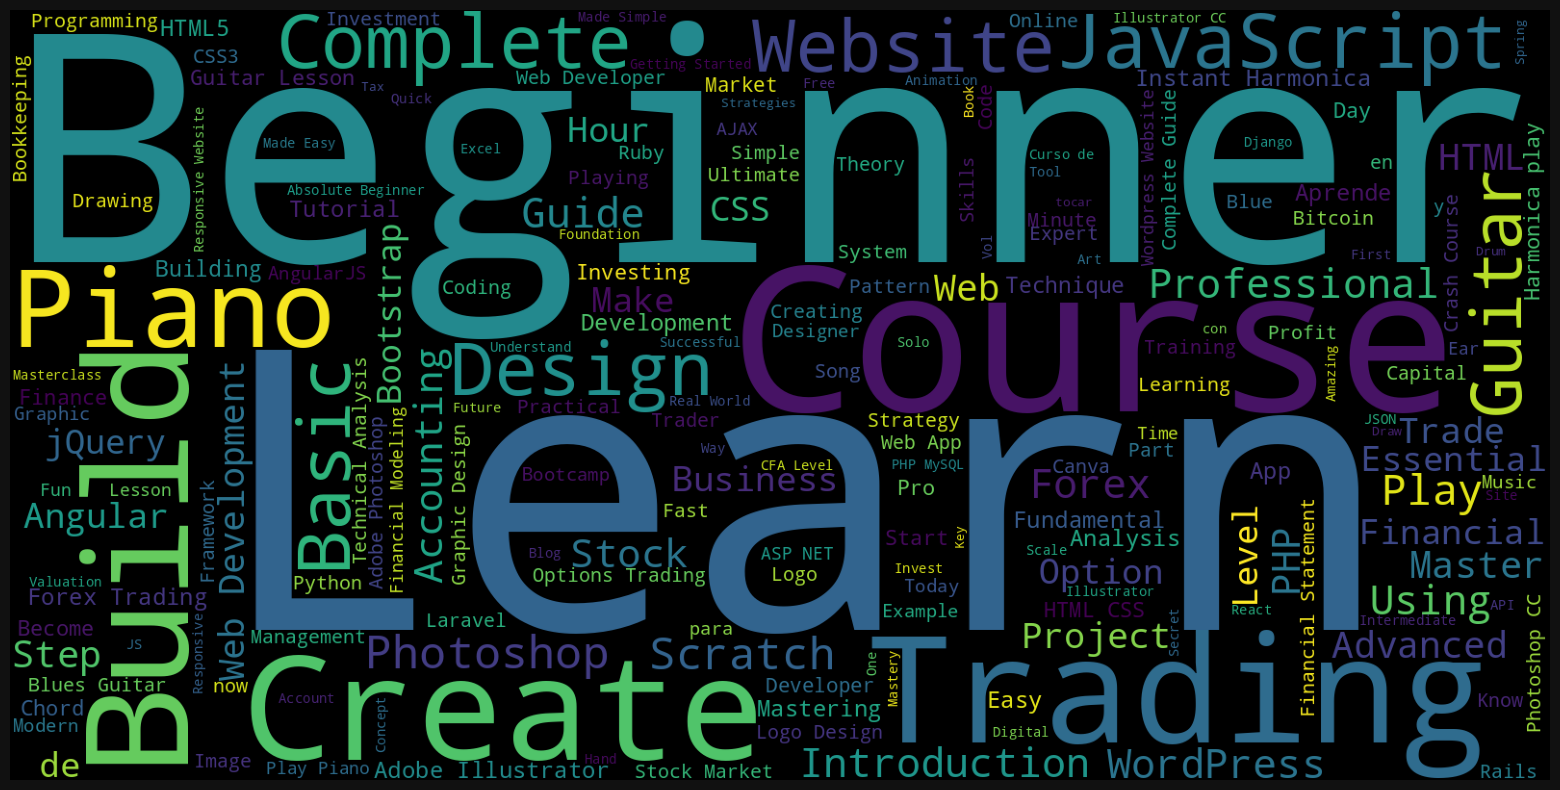

In [29]:
# Extracting the course titles and joining sentences into a single string
content_text = df["course_title"] 
content_text_string = " ".join(content_text.tolist())  

# Set other parameters
wordcloud = WordCloud(width=1600, height=800).generate(content_text_string)

plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordcloud.png', facecolor='k')

In [30]:
# Use wordcloud.words_ to get list of all words
words = ['Beginner', 'Learn', 'Course']
search_words = set(words)

for i in range(len(df)):
    string = df.iloc[i]['course_title']
    result = search_words.intersection(string.split())
    df.at[i, 'course_title'] = 1.0 if len(result) != 0 else 0.0

### Correlation analysis

In [31]:
# Creating another copy of dataframe
Temp_df = df.copy()

In [32]:
columns_to_encode = ['is_paid', 'subject']
Temp_df = pd.get_dummies(Temp_df, columns=columns_to_encode, dtype=int)

oe_rating = OrdinalEncoder(categories=[['All Levels', 'Beginner Level', 'Intermediate Level', 'Expert Level']],handle_unknown="use_encoded_value",unknown_value=np.nan)
Temp_df['level'] = oe_rating.fit_transform(Temp_df['level'].values.reshape(-1,1)).reshape(-1)

In [33]:
Temp_df[Temp_df.columns].corr()

,price,num_reviews,num_lectures,level,content_duration,year,month,day,hour_UTC,num_subscribers,is_paid_False,is_paid_True,subject_Business Finance,subject_Graphic Design,subject_Musical Instruments,subject_Web Development
price,1.000000,0.178351,0.359724,-0.062881,0.334612,0.130658,0.026341,0.020523,0.018329,0.129706,-0.335774,0.335774,0.030511,-0.065765,-0.119286,0.122229
num_reviews,0.178351,1.000000,0.316467,-0.060513,0.301138,-0.164509,0.040743,0.011719,-0.031411,0.806617,0.276349,-0.276349,-0.137126,-0.146225,-0.268407,0.479752
num_lectures,0.359724,0.316467,1.000000,-0.097906,0.800654,-0.000123,0.014578,0.020162,-0.010679,0.205862,-0.183869,0.183869,-0.141024,-0.100187,-0.000616,0.222012
level,-0.062881,-0.060513,-0.097906,1.000000,-0.079332,0.083919,-0.037292,0.014092,-0.018603,-0.094296,0.026423,-0.026423,-0.041459,-0.005669,0.087001,-0.026956
content_duration,0.334612,0.301138,0.800654,-0.079332,1.000000,-0.060707,-0.028496,0.010836,-0.033559,0.164509,-0.168468,0.168468,-0.063263,-0.080756,-0.103784,0.215155
year,0.130658,-0.164509,-0.000123,0.083919,-0.060707,1.000000,-0.283301,-0.020651,0.091155,-0.198648,0.033773,-0.033773,-0.048828,0.041920,-0.044422,0.052627
month,0.026341,0.040743,0.014578,-0.037292,-0.028496,-0.283301,1.000000,0.006006,0.039266,0.048978,-0.032674,0.032674,-0.017038,-0.035117,-0.005063,0.049440
day,0.020523,0.011719,0.020162,0.014092,0.010836,-0.020651,0.006006,1.000000,-0.005028,0.021196,0.025459,-0.025459,-0.028021,-0.007159,0.027535,0.010690
hour_UTC,0.018329,-0.031411,-0.010679,-0.018603,-0.033559,0.091155,0.039266,-0.005028,1.000000,-0.033799,-0.028124,0.028124,0.006087,-0.011212,0.005835,-0.002015
num_subscribers,0.129706,0.806617,0.205862,-0.094296,0.164509,-0.198648,0.048978,0.021196,-0.033799,1.000000,0.319543,-0.319543,-0.158203,-0.141881,-0.258779,0.489304


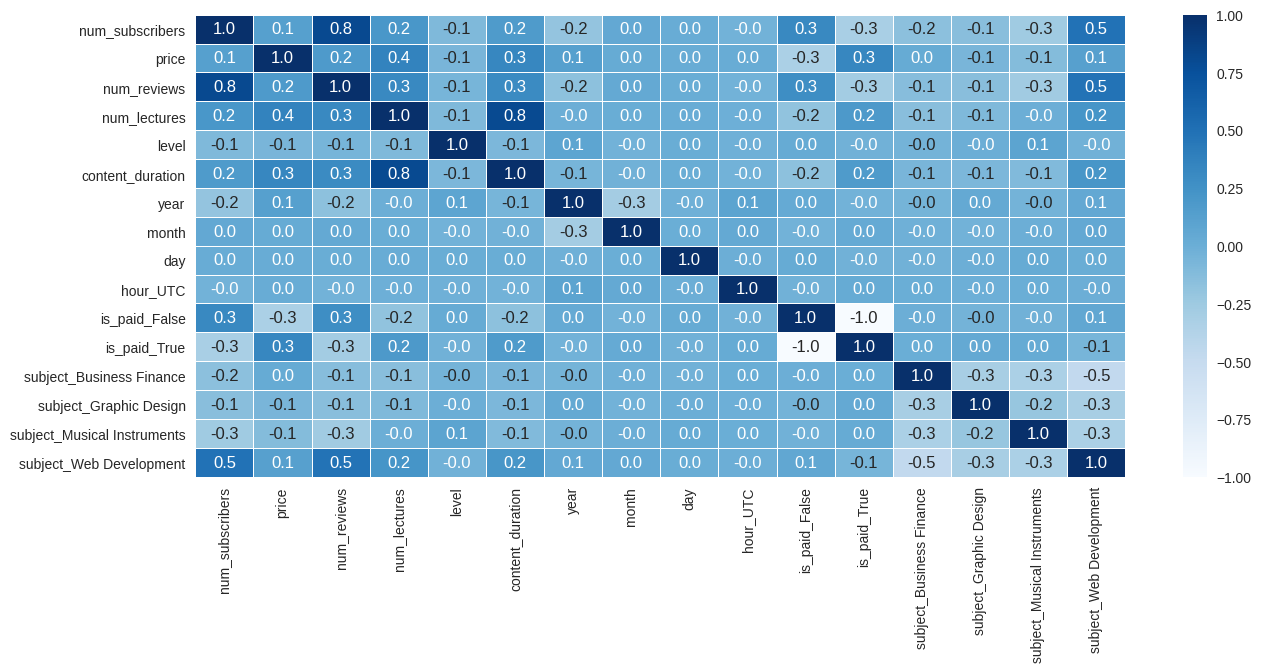

In [34]:
plt.figure(figsize=(15, 6))
cols = ['num_subscribers','course_title', 'price', 'num_reviews',
       'num_lectures', 'level', 'content_duration', 'year', 'month', 'day',
       'hour_UTC', 'is_paid_False', 'is_paid_True', 'subject_Business Finance',
       'subject_Graphic Design', 'subject_Musical Instruments',
       'subject_Web Development']
sns.heatmap(Temp_df[cols].corr(), annot=True,cmap="Blues", fmt=".1f",linewidth=.5)
plt.show()

In [35]:
# Dropping columns
Temp_df.drop(['year', 'month', 'day','hour_UTC','is_paid_True','price','level'],axis=1,inplace=True)

In [36]:
Temp_df.corr()

,num_reviews,num_lectures,content_duration,num_subscribers,is_paid_False,subject_Business Finance,subject_Graphic Design,subject_Musical Instruments,subject_Web Development
num_reviews,1.000000,0.316467,0.301138,0.806617,0.276349,-0.137126,-0.146225,-0.268407,0.479752
num_lectures,0.316467,1.000000,0.800654,0.205862,-0.183869,-0.141024,-0.100187,-0.000616,0.222012
content_duration,0.301138,0.800654,1.000000,0.164509,-0.168468,-0.063263,-0.080756,-0.103784,0.215155
num_subscribers,0.806617,0.205862,0.164509,1.000000,0.319543,-0.158203,-0.141881,-0.258779,0.489304
is_paid_False,0.276349,-0.183869,-0.168468,0.319543,1.000000,-0.004790,-0.040832,-0.028368,0.061309
subject_Business Finance,-0.137126,-0.141024,-0.063263,-0.158203,-0.004790,1.000000,-0.309837,-0.333323,-0.473789
subject_Graphic Design,-0.146225,-0.100187,-0.080756,-0.141881,-0.040832,-0.309837,1.000000,-0.216946,-0.308369
subject_Musical Instruments,-0.268407,-0.000616,-0.103784,-0.258779,-0.028368,-0.333323,-0.216946,1.000000,-0.331744
subject_Web Development,0.479752,0.222012,0.215155,0.489304,0.061309,-0.473789,-0.308369,-0.331744,1.000000


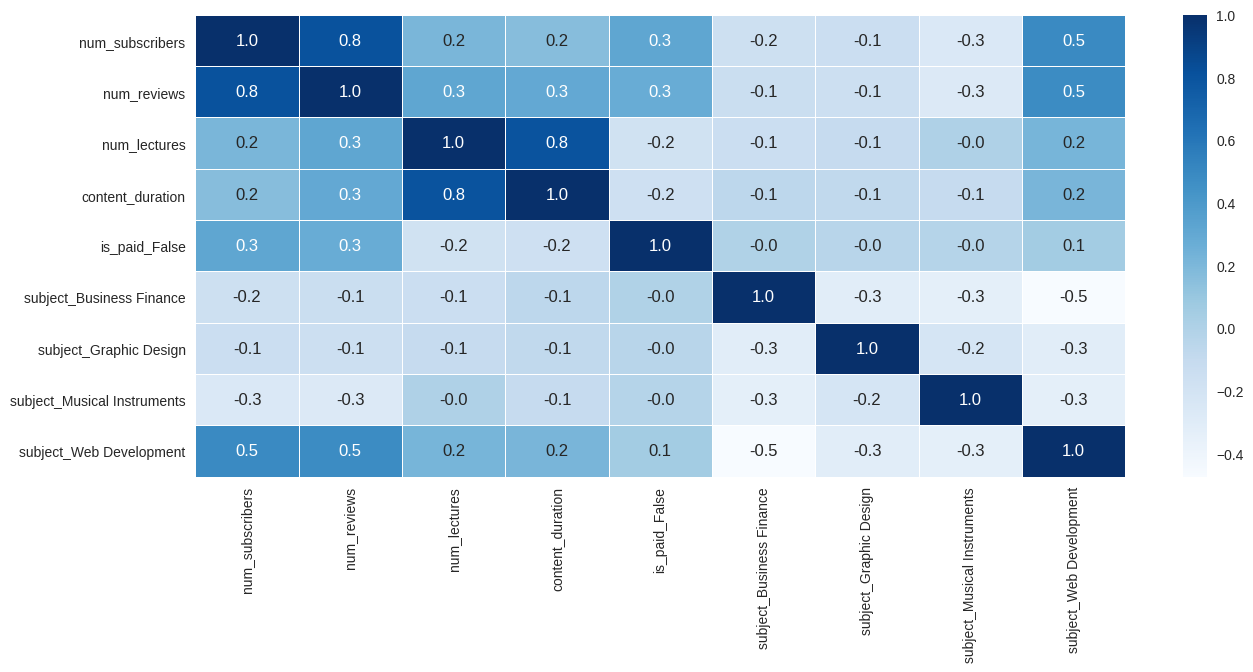

In [37]:
plt.figure(figsize=(15, 6))
cols = ['num_subscribers','course_title', 'num_reviews',
       'num_lectures', 'content_duration', 'is_paid_False',
       'subject_Business Finance', 'subject_Graphic Design',
       'subject_Musical Instruments', 'subject_Web Development']

sns.heatmap(Temp_df[cols].corr(), annot=True,cmap="Blues", fmt=".1f",linewidth=.5)
plt.show()

In [38]:
# One hot encoding
columns_to_encode = ['is_paid', 'subject']
df = pd.get_dummies(df, columns=columns_to_encode, dtype=int)

df.drop(['year', 'month', 'day','hour_UTC','is_paid_True','price','level'],axis=1,inplace=True)

In [39]:
# Merging 2 features into 1
subject_creative = [1 if df.iloc[i]['subject_Graphic Design'] == 1 or df.iloc[i]['subject_Musical Instruments'] == 1 else 0 for i in range(len(df))]
df['subject_creativity'] = subject_creative
df.drop(['subject_Graphic Design', 'subject_Musical Instruments'],inplace=True,axis=1)

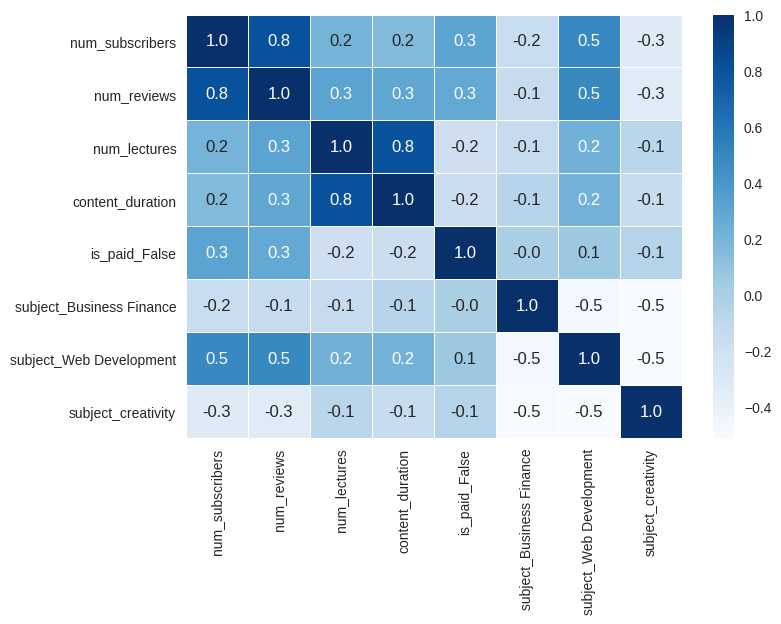

In [40]:
cols = ['num_subscribers','course_title', 'num_reviews', 'num_lectures', 'content_duration',
        'is_paid_False', 'subject_Business Finance',
       'subject_Web Development', 'subject_creativity']

sns.heatmap(df[cols].corr(), annot=True,cmap="Blues", fmt=".1f",linewidth=.5)
plt.show()

### Data processing

In [41]:
# Scaling the values
scaling = ColumnTransformer(transformers = [
    ('Stand_scaling',MinMaxScaler(),[1,2,3])
],remainder='passthrough')


# Building a pipeline
pipe = Pipeline(steps = [
    ('Scaling',scaling)
])

In [42]:
# Scaling training data using pipeline
X_train = df.drop(['num_subscribers'],axis=1)
X_train = pipe.fit_transform(X_train,y_train)

scaling = MinMaxScaler()
y_train = scaling.fit_transform(df['num_subscribers'].values.reshape(-1, 1)).reshape(-1)

# Model comparision using Pycaret

In [43]:
Input = df.drop(['num_subscribers'],axis = 1)
Output = df['num_subscribers']

Input = pipe.transform(Input)

In [44]:
pycaret_set = setup(data = Input,target = Output.values,train_size = 0.8,preprocess=False)

,Description,Value
0,Session id,2611
1,Target,target
2,Target type,Regression
3,Original data shape,"(2896, 9)"
4,Transformed data shape,"(2896, 9)"
5,Transformed train set shape,"(2316, 9)"
6,Transformed test set shape,"(580, 9)"
7,Categorical features,8


In [47]:
# All the models
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
# Let's get the best model
best_model = compare_models(fold=5, cross_validation=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:46:34
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2.1787,7.3411,2.7080,0.6979,0.3435,0.3266,0.0740
lr,Linear Regression,2.2626,7.5259,2.7422,0.6902,0.3701,0.3460,0.6840
ridge,Ridge Regression,2.2649,7.5281,2.7426,0.6901,0.3718,0.3485,0.4940
lar,Least Angle Regression,2.2635,7.5266,2.7423,0.6901,0.3697,0.3457,0.0140
br,Bayesian Ridge,2.2637,7.5267,2.7424,0.6901,0.3702,0.3463,0.0120
huber,Huber Regressor,2.2410,7.5992,2.7553,0.6872,0.3572,0.3218,0.0180
ada,AdaBoost Regressor,2.4153,8.1819,2.8599,0.6631,0.4022,0.4062,0.0300
rf,Random Forest Regressor,2.2935,8.4568,2.9053,0.6523,0.3653,0.3407,0.1340
knn,K Neighbors Regressor,2.3219,8.7072,2.9505,0.6416,0.3687,0.3518,0.0180
et,Extra Trees Regressor,2.3497,9.2543,3.0385,0.6196,0.3830,0.3491,0.1080


Processing:   0%|          | 0/81 [00:00<?, ?it/s]